En el 1977, John W. Tukey escribe el libro "Exploratory Data Analysis", indicando el problema que había con la implicación en los Test de Hipótesis (CDA) y el poco EDA que había. 

Los objetivos del EDA son: 



*   Conseguir nuevos descubrimientos gracias a los datos.
*   Sugerir causas para los fenómenos.
*   Evaluar los supuestos de la inferencia estadística.
*   Ayudar a la creación de herramientas y técnicas apropiadas.
*   Dar una base para una mayor recopilación de datos con encuestas o experimentos.


Es por esto que se basa en transformar los datos, visualizarlos, analizar e interpretarlos y documentar.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Setup

## Import libraries

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Read data

In [3]:
train = pd.read_csv('train.csv',
                      na_values = "NA",
                      sep=",")
y_train = train['SalePrice']
X_train = train.drop(['SalePrice'], axis = 1)
X_test = pd.read_csv('test.csv',
                      na_values = "NA",
                      sep=",")
dataset = X_train.append(X_test).reset_index(drop = True) #Join train & test features to make an appropriate EDA
dataset = dataset.drop(['Id'], axis = 1)

# Exploratory Data Analysis

## Información faltante
Empezamos por obtener en un data frame la cantidad de información faltante de cada columna tanto de los dato de entrenamiento como de los de pruebas:

In [4]:
missing_data = dataset.isnull().sum(axis = 0) #Generamos matriz booleana y sumamos los valores True por columnas
missing_data = missing_data[missing_data>0] #Filtramos las columnas con algún dato faltante
missing_data.sort_values(ascending = False) #Ordenamos las columnas

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

Vemos que existen variable con una gran cantidad de desinformación.

En la mayoría de los casos, se trata de que esa casa no posee una determinada instalación (por ejemplo, piscina), por lo que se ha dejado sin informar. Sin embargo, en los casos en los que la información es realmente faltante, se ha imputado la mediana o la moda por barrio, según sea la variable continua o discreta, respectivamente:


*   Reemplazamiento por la moda: MasVnrType, Functional, MSZoning, Utilities, Exterior1st, Exterior2nd, KitchenQual, SaleType.
*   Reemplazamiento por la mediana: LotFrontage, MasVnrArea


In [5]:
variables = ['Neighborhood', 'MasVnrType', 'Functional', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType', 'LotFrontage', 'MasVnrArea']
dataset_mode_median = dataset[variables]
transformation = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
dataset_mode_median = dataset_mode_median.fillna(dataset_mode_median.groupby('Neighborhood').transform(transformation))
dataset_mode_median.loc[:,'LotFrontage'] = dataset_mode_median.loc[:,'LotFrontage'].astype('float')

C:\Users\Andre\AppData\Local\Temp\ipykernel_18360\3706415312.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_mode_median.loc[:,'LotFrontage'] = dataset_mode_median.loc[:,'LotFrontage'].astype('float')



Existen otras formas de reemplazar valores nulos, como puede ser por ejemplo usar un algoritmo cluster, que se abordarán en otro ejemplo de EDA.

*   Reemplazamiento por el valor cero (variables cuantitativas): GarageCars, GarageArea, BsmtFullBath, BsmtHalfBath, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF
*   Reemplazamiento por el valor 'None' (variables cualitativas): 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'




In [6]:
dataset_zero = dataset.drop(variables, axis = 1) #Filtramos todas las que no hemos escogido antes
dataset_zero.update(dataset_zero.select_dtypes(exclude=[np.number]).fillna('None')) #De las que quedan, excluimos las variables numéricas y rellenamos con 'None'
dataset_zero.update(dataset_zero.select_dtypes(include=[np.number]).fillna(0.0)) #De las que quedan, las numéricas las rellenamos con 0

Juntamos de nuevo toda la información

In [7]:
dataset = pd.concat([dataset_mode_median, dataset_zero], axis = 1) #Juntamos ambos dataset por columnas
X_train = dataset.loc[dataset.index.isin(X_train.index),:] #Filtramos los índices de datos de entrenamiento
X_test = dataset.loc[dataset.index.isin(X_test.index),:] #Filtramos los índices de datos test

*¡Ya no hay información faltante!*

In [8]:
missing_data = dataset.isnull().sum(axis = 0) #Generamos matriz booleana y sumamos los valores True por columnas
missing_data = missing_data[missing_data>0] #Filtramos las columnas con algún dato faltante
missing_data.sort_values(ascending = False) #Ordenamos las columnas

Series([], dtype: int64)

Finalmente, convertimos las variables tipo *int* a *float* para estudiarlas en la matriz de correlación:

In [9]:
dataset.loc[:,dataset.select_dtypes(include=np.number).columns] = (dataset.select_dtypes(include=np.number)).astype(float)

C:\Users\Andre\AppData\Local\Temp\ipykernel_18360\1836205721.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:,dataset.select_dtypes(include=np.number).columns] = (dataset.select_dtypes(include=np.number)).astype(float)


## Visualización

Veamos, en primer lugar, un estudio por densidad de la variable de respuesta, el precio de las casas en los datos de entrenamiento:

C:\Users\Andre\AppData\Local\Temp\ipykernel_18360\3659132393.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'] , fit=stats.norm); #Distribución de precios



 mu = 180921.20 and sigma = 79415.29



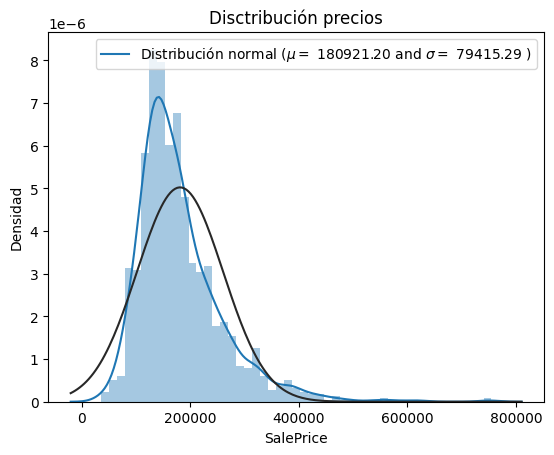

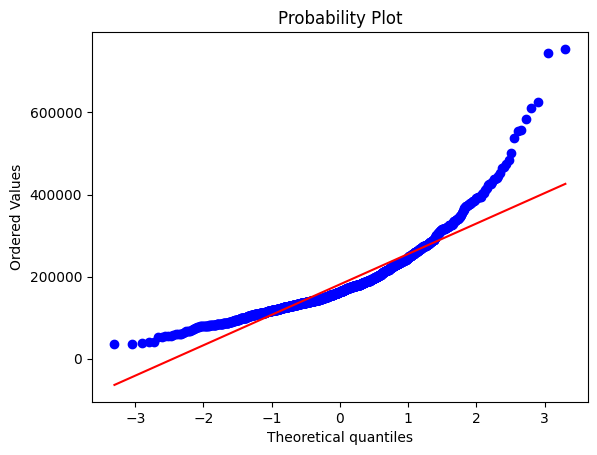

In [10]:
from scipy import stats
train_data = pd.concat([X_train, y_train], axis = 1) #Datos de entrenamiento

sns.distplot(train_data['SalePrice'] , fit=stats.norm); #Distribución de precios

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(train_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Distribución normal ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Densidad')
plt.title('Disctribución precios')

#Mostramos QQ-plot
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

Los modelos obtienen un comportamiento mucho más afinado cuando nuestra vairable respuesta posee un comportamiento normal, lo que motiva la siguiente transformación


 mu = 12.02 and sigma = 0.40



C:\Users\Andre\AppData\Local\Temp\ipykernel_18360\308760403.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'] , fit=stats.norm);


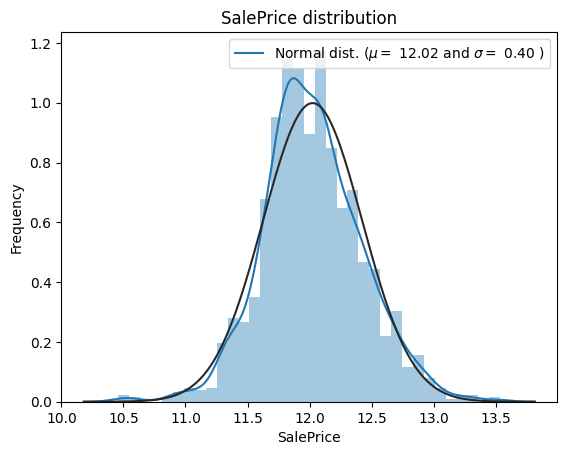

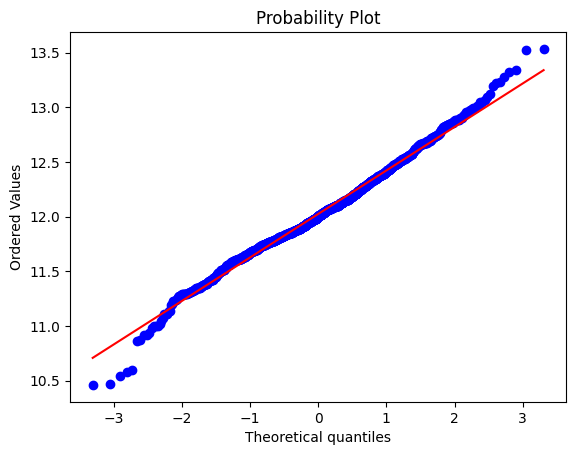

In [11]:
#Este comando aplica la función log(1+x)
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])
y_train = train_data["SalePrice"]

#Comprobamos la nueva distribución
sns.distplot(train_data['SalePrice'] , fit=stats.norm);

# Parámetros normales
(mu, sigma) = stats.norm.fit(train_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Dibujamos la distribución
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

Seguidamente, estudiamos en base a esta cuál es la correlación que muestran el resto de variables numéricas:

C:\Users\Andre\AppData\Local\Temp\ipykernel_18360\3576779538.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<Axes: >

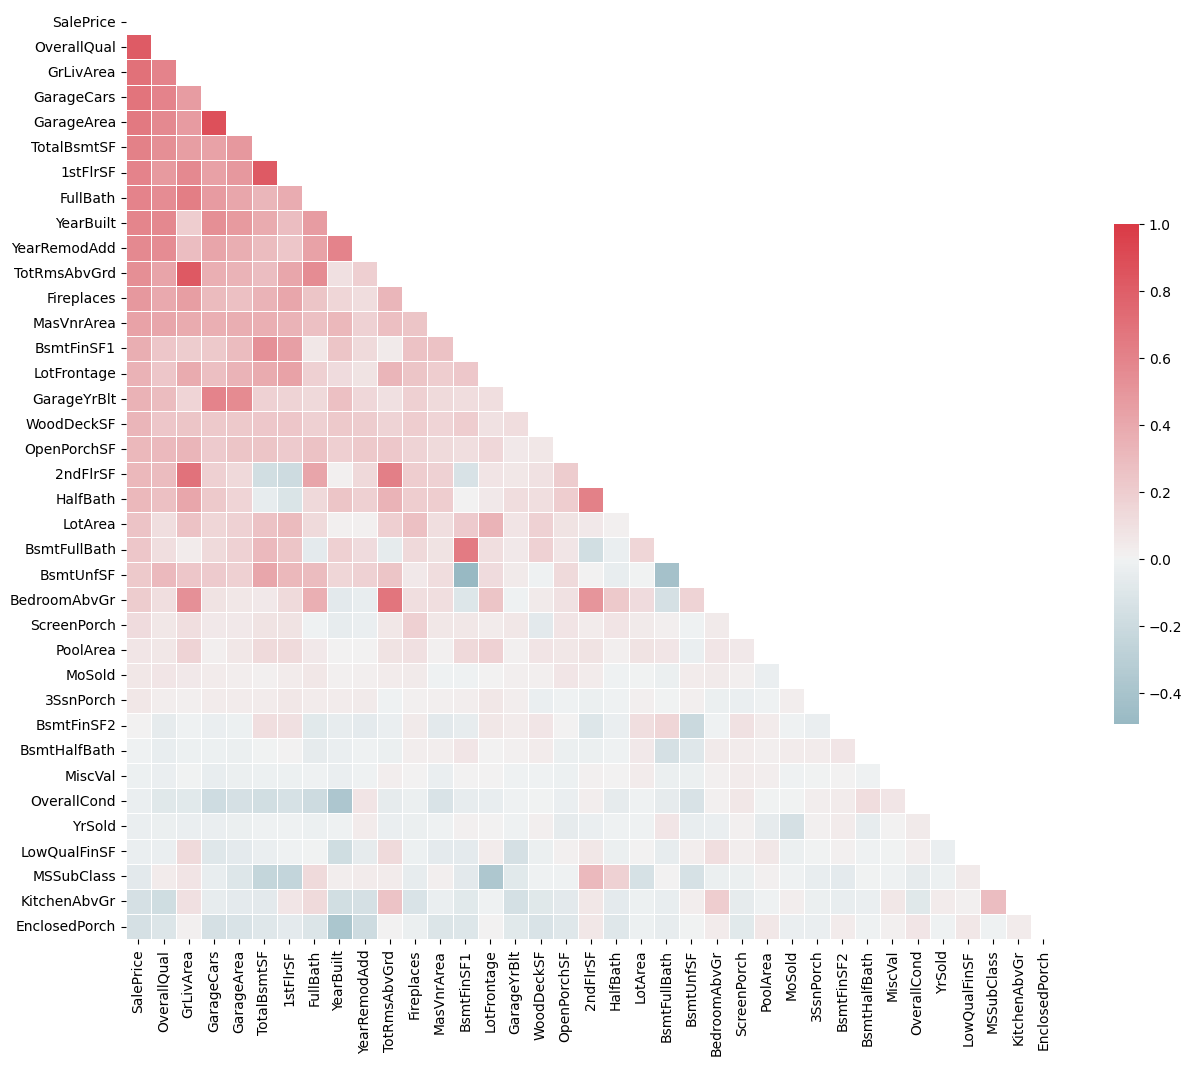

In [12]:
corr = train_data.corr(method = 'pearson').sort_values(by = 'SalePrice', axis = 0, ascending = False).sort_values(by = 'SalePrice', axis = 1, ascending = False)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.iloc[0:37,0:37], mask=mask[0:37,0:37], cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = False)

En particular, vamos a mostrar un gráfico de las dos variables que mayor correlación poseen con la variable respuesta:


*   OverallQual:



<Axes: xlabel='OverallQual', ylabel='SalePrice'>

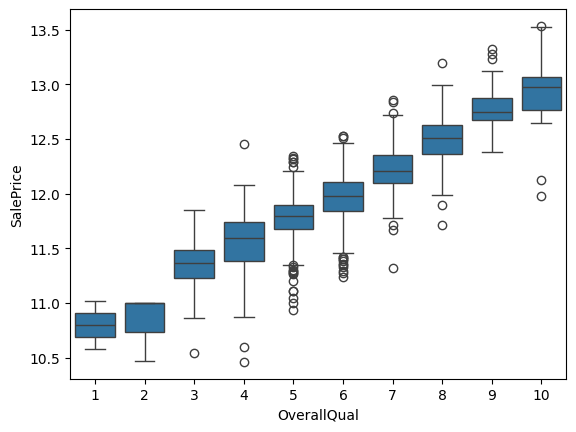

In [13]:
sns.boxplot(data = train_data, x = 'OverallQual', y = 'SalePrice')

 * GrLivArea:


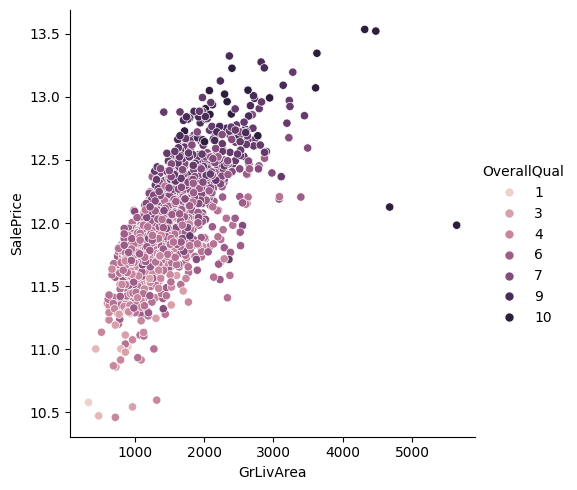

In [14]:
sns.relplot(data = train_data, x = 'GrLivArea', y = 'SalePrice', hue = 'OverallQual')

Sobre este último gráfico (que estudia la variable respuesta frente a la superficie de vivienda) vemos que existen determinados valores que se alejan demasiado del comportamiento asintótico general de la distribución, lo que motiva la introducción del siguiente apartado, en el que en particular se estudian los outliers del dato.

## Valores atípicos
Para esta parte, definiremos dos nuevas variables que nos ayudarán a agrupar las casas, que son el área total de la casa y una discretización de la misma, junto con la calidad general de la casa:

In [15]:
#Área total
dataset['TotalArea'] = dataset['GrLivArea'] + dataset['TotalBsmtSF']
train_data = pd.concat([dataset.loc[dataset.index.isin(train_data.index),:], y_train], axis = 1)
print(train_data[['TotalArea','GrLivArea','TotalBsmtSF','SalePrice']].corr())

             TotalArea  GrLivArea  TotalBsmtSF  SalePrice
TotalArea     1.000000   0.880324     0.822888   0.773277
GrLivArea     0.880324   1.000000     0.454868   0.700927
TotalBsmtSF   0.822888   0.454868     1.000000   0.612134
SalePrice     0.773277   0.700927     0.612134   1.000000


Vemos que la correlación de esta última variable que hemos creado es mejor que sus predecesoras con respecto al precio, por lo que nos quedamos con esta última, y recogemos los cambios en los datos con información de precios disponible

In [16]:
dataset = dataset.drop(['GrLivArea','TotalBsmtSF'], axis = 1)
train_data = pd.concat([dataset.loc[dataset.index.isin(train_data.index),:], y_train], axis = 1)

Discretizamos ahora la superficie total de la casa basándonos en los percentiles 1/3, 2/3 y 0.9. Esta variable se usará simplemente para estudiar valores atípicos y no formará parte del modelo, por lo que la guardamos en un vector aparte:

In [17]:
# Creamos una lista de condicionales
conditions = [
    (train_data['TotalArea'] <= np.quantile(train_data['TotalArea'],0.33)),
    (train_data['TotalArea'] > np.quantile(train_data['TotalArea'],0.33)) & (train_data['TotalArea'] <= np.quantile(train_data['TotalArea'],0.66)),
    (train_data['TotalArea'] > np.quantile(train_data['TotalArea'],0.66)) & (train_data['TotalArea'] <= np.quantile(train_data['TotalArea'],0.9)),
    (train_data['TotalArea'] > np.quantile(train_data['TotalArea'],0.9))
    ]

# Definimos los valores en base a dichos condicionales
values = ['Small', 'Medium', 'Big', 'Huge']

# Creamos la variable discretizada
train_data['TotalAreaDisc'] = np.select(conditions, values)

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

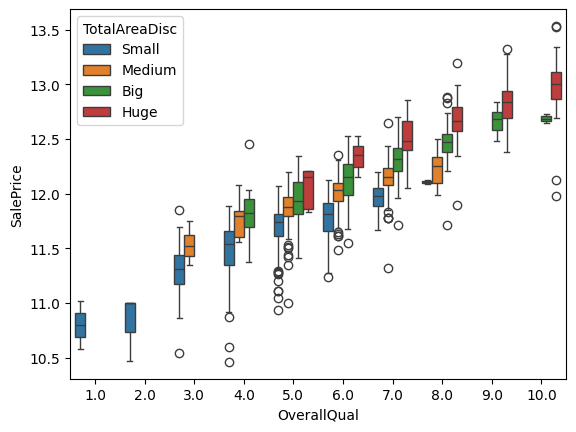

In [18]:
sns.boxplot(data = train_data, x = 'OverallQual', y = 'SalePrice', hue = 'TotalAreaDisc', hue_order=['Small', 'Medium', 'Big', 'Huge'])

Finalmente, una vez tenemos la superficie total, tiene sentido estudiar la variable precio por metro cuadrado para ver posibles valores atípicos, y contrastarla con el barrio en el que se localiza la vivienda. Esta variable, de nuevo, es puramente indicativa y no formará parte de nuestros datos:

In [19]:
train_data['PricePerSM'] = (np.exp(train_data['SalePrice'])-1)/train_data['TotalArea']

<Axes: xlabel='OverallQual', ylabel='PricePerSM'>

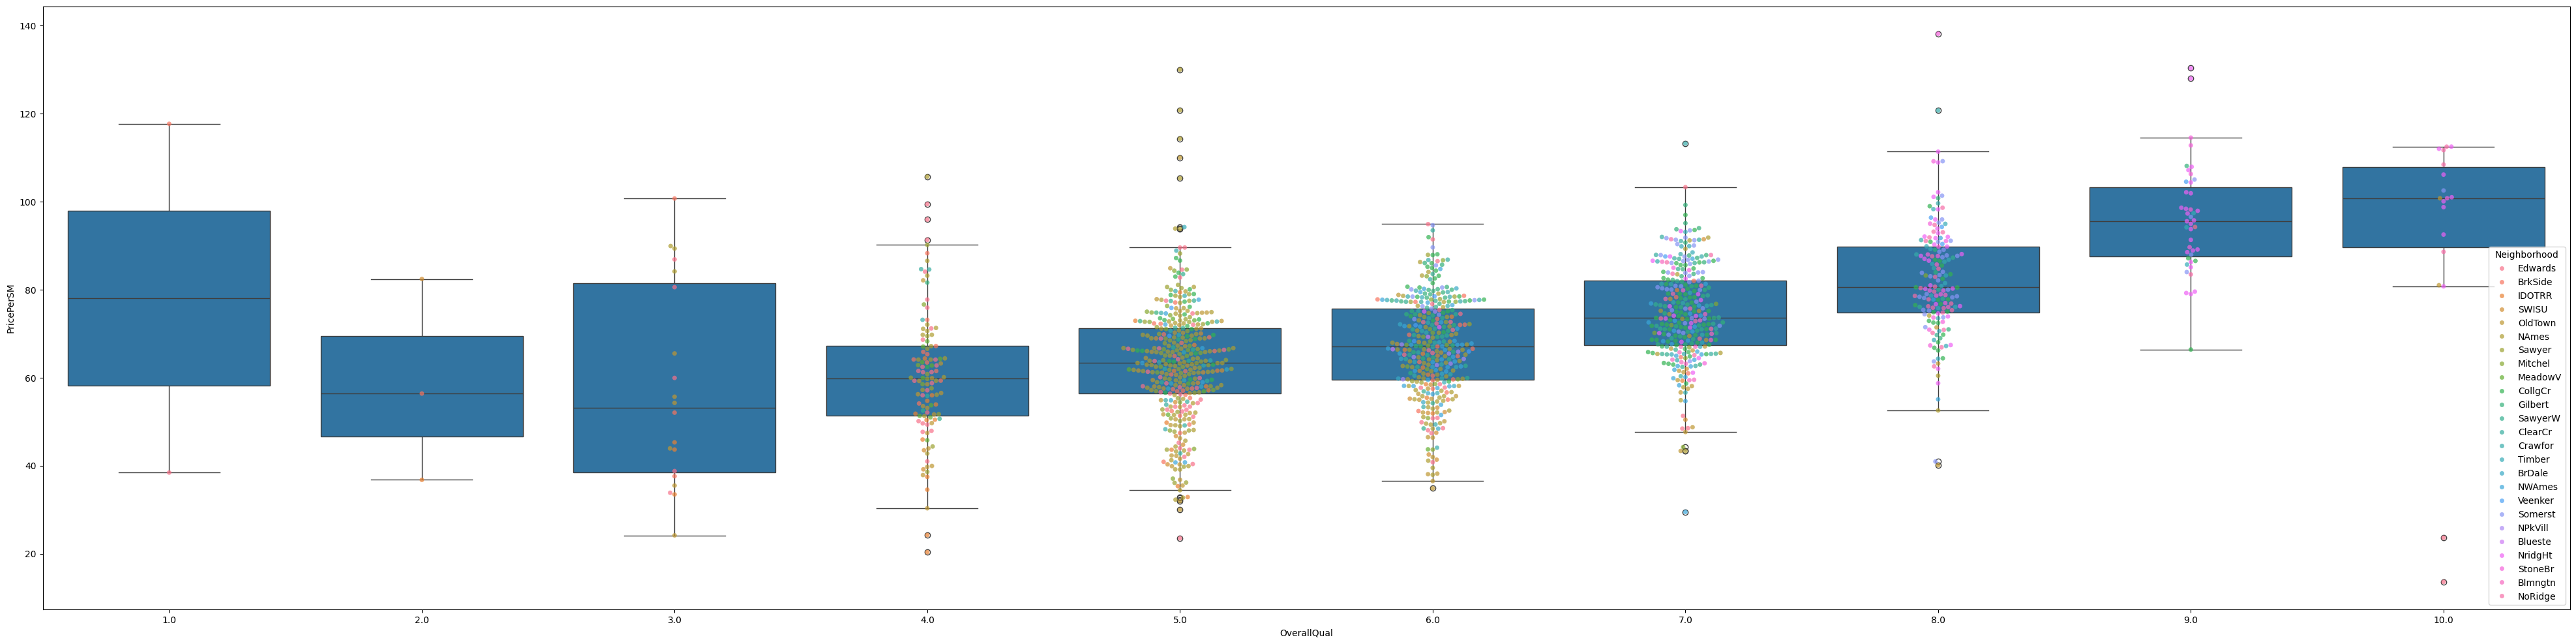

In [20]:
a4_dims = (50, 12)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data = train_data, x = 'OverallQual', y = 'PricePerSM', ax = ax)
sns.swarmplot(data = train_data, x = 'OverallQual', y = 'PricePerSM', hue = 'Neighborhood', alpha = .7)

Con el anterior gráfico podemos contemplar de manera muy evidente el objetivo de esta parte del estudio, que es corregir valores atípicos. En él, analizamos la variable que acabamos de definir de precio por unidad de superficie frente  la calidad general de la casa, observando que hay valores particularmente disonantes de precios muy económicos en casas que obtienen una puntuación de diez y además son de las más grandes de la muestra:

In [21]:
def replace_outliers(data, group_variables, label):
  '''
  Parameters
  ----------
  data : pandas.DataFrame
      Object where our data lies.
  group_variables : list
      List where we store the variables we want to take into account when replacing outliers.
  label : list
      List-formatted label.

  Raises
  ------
  numpy.array containing the label column(s) with outliers replaced.
  '''
  data_aux = data
  Q3 = data_aux[group_variables + label].groupby(group_variables).quantile(.75)
  Q1 = data_aux[group_variables + label].groupby(group_variables).quantile(.25)
  IQR = Q3-Q1
  upper_limit = Q3+1.5*IQR
  lower_limit = Q1-1.5*IQR
  upper_limit.columns = [col + '_ul' for col in label]
  lower_limit.columns = [col + '_ll' for col in label]
  data_aux = data_aux.join(upper_limit, on = group_variables, how = 'left')
  data_aux.loc[data_aux.loc[:,label].values[:,0] > data_aux.loc[:,upper_limit.columns].values[:,0],label] = data_aux.loc[data_aux.loc[:,label].values[:,0] > data_aux.loc[:,upper_limit.columns].values[:,0],upper_limit.columns].values
  data_aux = data_aux.join(lower_limit, on = group_variables, how = 'left')
  data_aux.loc[data_aux.loc[:,label].values[:,0] < data_aux.loc[:,lower_limit.columns].values[:,0],label] = data_aux.loc[data_aux.loc[:,label].values[:,0] < data_aux.loc[:,lower_limit.columns].values[:,0],lower_limit.columns].values
  return data_aux.loc[:,label].values

In [22]:
train_data.loc[:,'PricePerSM'] = replace_outliers(train_data, ['OverallQual'], ['PricePerSM'])
train_data.loc[:,'SalePrice'] = np.log1p(train_data.loc[:,'PricePerSM'])*train_data.loc[:,'TotalArea']

*¡Ya no hay outliers!*

<Axes: xlabel='OverallQual', ylabel='PricePerSM'>

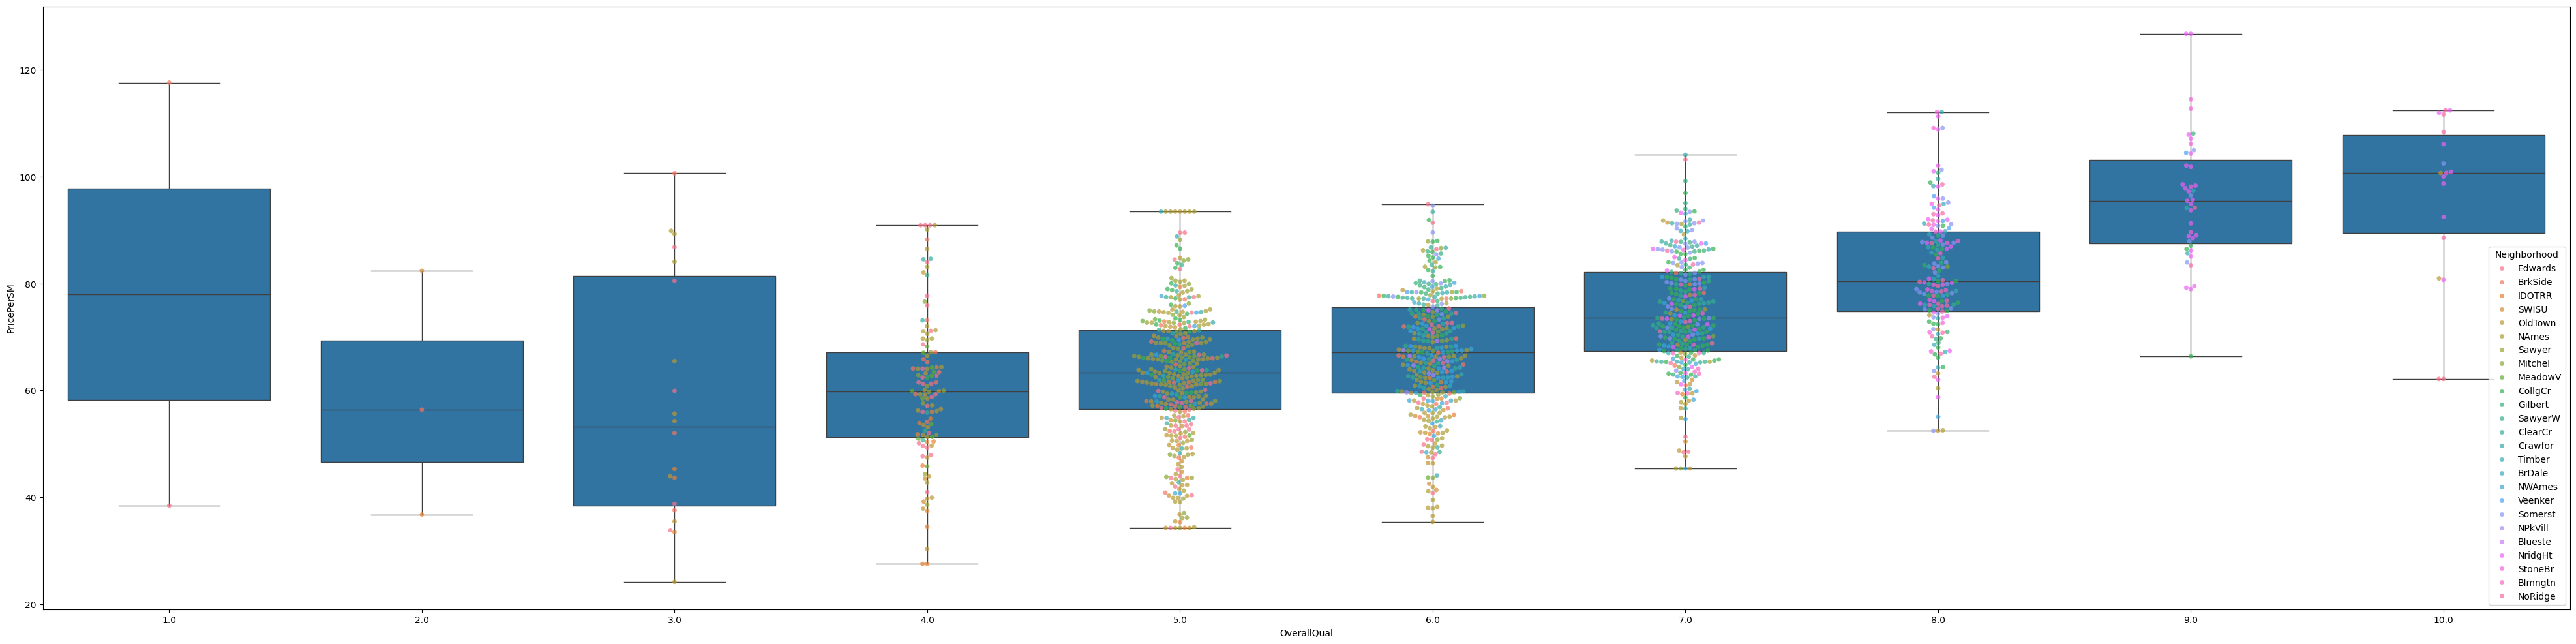

In [23]:
a4_dims = (50, 12)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data = train_data, x = 'OverallQual', y = 'PricePerSM', ax = ax)
sns.swarmplot(data = train_data, x = 'OverallQual', y = 'PricePerSM', hue = 'Neighborhood', alpha = .7)

Eliminamos las variables auxiliares

In [24]:
train_data = train_data.drop(['PricePerSM', 'TotalAreaDisc'], axis = 1)

## Variables altamente correlacionadas

Finalmente, nos disponemos a eliminar del modelo variables que aporten una información linearmente similar al mismo. La lógica será la siguiente:

1.   Analizamos de la matriz de correlación en busca de valores que sean superior a un cierto *threshold* (en nuestro caso, .75)
2.   De entre ambas variables con un índice de correlación tan alto, eliminamos aquella que tenga menor corficiente de correlación con la variable respuesta.





In [25]:
#Implementación rudimentaria
def high_correlated_data(data, label, threshold):
  data.corr(method = 'pearson').sort_values(by = label, axis = 0, ascending = False).sort_values(by = label, axis = 1, ascending = False)
  var_out = []
  for idx in range(1,corr.shape[0]): #Descartamos de los índices la propia variable respuesta
    for col in range(idx+1,corr.shape[1]): #Descartamos de las columnas la propia variable respuesta
      if ((corr.iloc[idx,col]>threshold) & (corr.iloc[idx,0]>corr.iloc[0,col])):
        var_out.append(corr.columns[col])
        print('Variables {var1} and {var2} are highly correlated ({corr:.3f}), but since {var1}-label correlation is {corr1:.3f} and {var2}-label correlation is {corr2:.3f}, we get rid of {var2}'.format(var1 = corr.index[idx],var2 = corr.columns[col],corr = corr.iloc[idx,col],corr1 = corr.iloc[idx,0],corr2 = corr.iloc[0,col]))
      elif ((corr.iloc[idx,col]>threshold) & (corr.iloc[idx,0]<corr.iloc[0,col])):
        var_out.append(corr.index[idx])
        print('Variables {var1} and {var2} are highly correlated ({corr:.3f}), but since {var1}-label correlation is {corr1:.3f} and {var2}-label correlation is {corr2:.3f}, we get rid of {var1}'.format(var1 = corr.index[idx],var2 = corr.columns[col],corr = corr.iloc[idx,col],corr1 = corr.iloc[idx,0],corr2 = corr.iloc[0,col]))
      else:
        continue
  return var_out

In [26]:
high_correlated_data(train_data, ['SalePrice'], .75)

Variables GrLivArea and TotRmsAbvGrd are highly correlated (0.825), but since GrLivArea-label correlation is 0.701 and TotRmsAbvGrd-label correlation is 0.534, we get rid of TotRmsAbvGrd
Variables GarageCars and GarageArea are highly correlated (0.882), but since GarageCars-label correlation is 0.681 and GarageArea-label correlation is 0.651, we get rid of GarageArea
Variables TotalBsmtSF and 1stFlrSF are highly correlated (0.820), but since TotalBsmtSF-label correlation is 0.612 and 1stFlrSF-label correlation is 0.597, we get rid of 1stFlrSF


['TotRmsAbvGrd', 'GarageArea', '1stFlrSF']

In [27]:
#Implementación optimizada
threshold = .75
var_out = [corr.columns[col] if ((corr.iloc[idx,col]>threshold) & (corr.iloc[idx,0]>corr.iloc[0,col])) else corr.index[idx] if ((corr.iloc[idx,col]>threshold) & (corr.iloc[idx,0]<corr.iloc[0,col])) else 0 for idx in range(1,corr.shape[0]) for col in range(idx+1,corr.shape[1])]
var_out = [var for var in var_out if var!=0]
print(var_out)

['TotRmsAbvGrd', 'GarageArea', '1stFlrSF']


Eliminamos dichas variables de los datos de entrenamiento, y adaptamos todos los cambios anteriores a los datos test:

In [28]:
#Datos entrenamiento
train_data = train_data.drop(var_out, axis = 1)
X_train = train_data.drop(['SalePrice'], axis = 1)
#Datos test
X_test = dataset.loc[X_test.index,~dataset.columns.isin(var_out)]
#Todo
dataset = pd.concat([X_train, X_test], axis = 0)

## Skewness

Observamos ahora la simetría de las variables numéricas, a fin de aplicar la transformación Box-Cox:

In [29]:
numeric_vars = dataset.select_dtypes(include = ['int', 'float'])
# Check the skew of all numerical features
skewed_feats = numeric_vars.apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head())

                   Skew
MiscVal       24.447459
PoolArea      14.810563
LotArea       12.193015
3SsnPorch     10.291942
LowQualFinSF   9.000483


In [30]:
from scipy.special import boxcox1p #Librería
skewness = skewness.loc[abs(skewness.Skew) > 0.75,:] #Filtramos los que tengan un índice superior a .75
lambda_values = pd.Series(np.linspace(-2,2,40)) #Asignamos candidatos a índices de transformación
for var in skewness.index:
  skews = [stats.skew(boxcox1p(dataset[var], lam)) for lam in lambda_values]
  lam = lambda_values[pd.Series(np.abs(skews)).idxmin()] #Elegimos el índice óptimo
  dataset[var] = boxcox1p(dataset[var], lam)

## Codificado de variables categóricas

Ahora, a las variables que se corresponden con objetos les asignamos una numeración para que sean interpretables por el modelo. Este hecho va asociado en primer lugar a que hay algunas variables que se interpretan como numéricas y que, sin embargo, no se deben tratar como tal

In [31]:
#Variables numéricas que no deben tratarse como tal
dataset['MSSubClass'] = dataset['MSSubClass'].apply(str)
dataset['YrSold'] = dataset['YrSold'].astype(str)
dataset['MoSold'] = dataset['MoSold'].astype(str)

Por una parte, de las que se puede inferir un cierto orden, se codificarán de manera más reducida con un *LabelEncoder()*

In [32]:
from sklearn.preprocessing import LabelEncoder #Librería
LabelEncoderCols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for col in LabelEncoderCols:
    encoder = LabelEncoder() 
    dataset.loc[:,[col]] = encoder.fit_transform(dataset[col])

C:\Users\Andre\AppData\Local\Temp\ipykernel_18360\1463067483.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:,[col]] = encoder.fit_transform(dataset[col])
C:\Users\Andre\AppData\Local\Temp\ipykernel_18360\1463067483.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:,[col]] = encoder.fit_transform(dataset[col])
C:\Users\Andre\AppData\Local\Temp\ipykernel_18360\1463067483.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a n

Por otra parte, de las que no se deduzca orden concreto, usamos *OneHotEncoder()*

In [33]:
from sklearn.preprocessing import OneHotEncoder #Librería
obj_vars = dataset.select_dtypes(include = 'object').columns #Columnas categóricas
encoder = OneHotEncoder() #Encoder
for var in obj_vars: #Entrenamos el encoder en cada variable
  encoder.fit(dataset.loc[:,[var]])
  enc_data = pd.DataFrame(encoder.transform(dataset.loc[:,[var]]).toarray(), columns = [var + '_' + typevar for typevar in encoder.categories_[0].tolist()], index = dataset.index)
  dataset = pd.concat([dataset, enc_data], axis = 1)
  dataset = dataset.drop([var], axis = 1)

# Modelización

A continuación, pasamos a estudiar los modelos predictivos que serán la forma de elaborar estimaciones de precios de viviendas, dado un cierto *input*

In [34]:
#Partición de los datos
from sklearn.model_selection import KFold

#Escalado de datos
from sklearn.preprocessing import StandardScaler

#Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


#Escalado de datos
scaler = StandardScaler()
scaler.fit(dataset)
X_train = scaler.transform(dataset.iloc[X_train.index,:])
X_test = scaler.transform(dataset.iloc[X_test.index,:])

#Partición de datos de entrenamiento para analizar modelos
n_splits = 8
kf = KFold(n_splits = n_splits)

#Diccionario de modelos
models={'OLS': LinearRegression(),
        'SVR': SVR(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'ElasticNet': ElasticNet(),
        'RandomForest': RandomForestRegressor(),
        'XGB': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
       }


#Bucle
for name, model in models.items():
  print('Probamos modelo {}:'.format(name))
  rsme = []
  for train_idx, test_idx in kf.split(X_train, y_train):
    model.fit(X_train[train_idx,:], y_train[train_idx])
    y_pred = model.predict(X_train[test_idx,:])
    rsme.append(np.sqrt(sum((np.expm1(y_train[test_idx])-np.expm1(y_pred))**2)))
  print('El RMSE medio de las estimaciones es: {:.2f}'.format(np.mean(rsme)))

Probamos modelo OLS:
El RMSE medio de las estimaciones es: inf
Probamos modelo SVR:
El RMSE medio de las estimaciones es: 524304.66
Probamos modelo Ridge:
El RMSE medio de las estimaciones es: 415887.19
Probamos modelo Lasso:
El RMSE medio de las estimaciones es: 1085947.21
Probamos modelo ElasticNet:
El RMSE medio de las estimaciones es: 1085947.21
Probamos modelo RandomForest:
El RMSE medio de las estimaciones es: 403999.77
Probamos modelo XGB:
El RMSE medio de las estimaciones es: 380622.87
